# Лабораторная работа №4
# Решение ДУЧП гиперболического типа

## 1. 2D уравнение конвекции

Необходимо решить уравнение конвекции
$$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x} = 0,$$
при распространении косинусоидального импульса $$\phi(x) = cos(0.5 \pi x), x \in [0,1]$$

#### Необходимые библиотеки

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [57]:
u, length, time, columns = 1., 1., 10, 20


def initial(x: float) -> float:
    return math.cos(math.pi * x / 2)


def first_border(t: float) -> float:
    return 0


def second_border(t: float) -> float:
    return 1

In [58]:
def explicity(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
        
    for i in range(0, lines + 1):
        T[i][0] = first_border(i * dt)
        T[0][columns] = second_border(i * dt)
    
    for k in range(lines):
        for j in range(1, columns):
            T[k + 1][j] = T[k][j] - c * (T[k][j + 1] - T[k][j - 1]) / 2
    return T, dt

In [59]:
def draw(dt: float, u: list) -> None:
    a, b = np.shape(u)
    x = np.linspace(0, length, b)
    fig = plt.figure()
    
    ax1 = fig.add_subplot(221)
    ax1.grid()
    plt.plot(x, u[int(0.1 / dt), :])

    ax2 = fig.add_subplot(222)
    ax2.grid()
    plt.plot(x, u[int(0.2 / dt), :])

    ax3 = fig.add_subplot(223)
    ax3.grid()
    plt.plot(x, u[int(5 / dt), :])

    ax4 = fig.add_subplot(224)
    ax4.grid()
    plt.plot(x, u[int(10 / dt), :])
    
    plt.show()

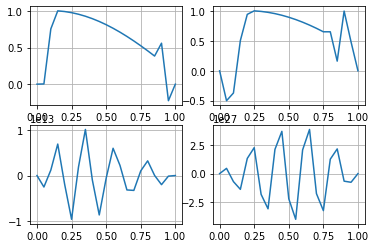

In [60]:
T, dt = explicity(c=1)
draw(dt, T)

In [52]:
def lax_wendroff(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
        
    for i in range(0, lines + 1):
        T[i][0] = first_border(i * dt)
        T[0][columns] = second_border(i * dt)
    
    for k in range(lines):
        for j in range(1, columns):
            F_p = (T[k][j + 1] + T[k][j]) / 2 - c * (T[k][j + 1] + T[k][j]) / 2
            F_l = (T[k][j] + T[k][j - 1]) / 2 - c * (T[k][j] + T[k][j] - 1) / 2
            T[k + 1][j] = T[k][j] - c * (F_p - F_l)
    return T, dt

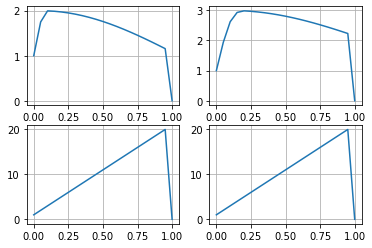

In [53]:
T, dt = test(c=1)
draw(dt, T)